In [1]:
import joblib
import cv2
import numpy as np
from matplotlib import pyplot as plot
from tqdm import tqdm
import os
# On some Linux systems setting file locking to false is also necessary:
import os
os.environ["HDF5_USE_FILE_LOCKING"]='FALSE' 
import h5py # needs conda/pip install h5py
import matplotlib.pyplot as plt
import pandas as pd
from sevir.display import get_cmap
import matplotlib

In [2]:
DATA_PATH    = '../../sevir_data_copy/data'
CATALOG_PATH = '../../sevir_data_copy/CATALOG.csv' 


In [3]:
from joblib import Parallel, delayed

In [4]:
data = joblib.load("./cluster_lght_data_2.pickle")

In [5]:
cluster_counts = []
for datapoint in data:
    if(datapoint is not None):
        for data_dict in datapoint[2]:
            for label in data_dict.keys():
                if(type(label) is not str):
                    cluster_counts.append(data_dict[label]["count"])

In [ ]:
[datapoint[0]+"_" + str(i) for datapoint in data if datapoint is not None for i in range(len(datapoint[1]))]

(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 5.05547355e-02, 5.94694637e-04, 3.83016895e-04,
        6.87054029e-04, 8.80459588e-04, 4.78758139e-02, 4.04204639e-03,
        3.00402667e-03, 3.26053616e-03, 3.96516344e-03, 4.69854693e-03,
        3.82648456e-02, 5.92048665e-03, 6.68102880e-03, 5.83052361e-03,
        7.30447966e-03, 2.75592438e-02, 7.04567367e-03, 5.66237959e-03,
        6.47484270e-03, 5.56293099e-03, 1.71118489e-02, 4.63184847e-03,
        4.60199392e-03, 4.06051827e-03, 3.91783549e-03, 3.56856721e-03,
        9.47817043e-03, 2.83478432e-03, 2.79464543e-03, 2.20684031e-03,
        2.48591544e-03, 5.66128127e-03, 2.00155284e-03, 1.61524096e-03,
        1.76970580e-03, 1.57889629e-03, 3.41070754e-03, 1.26826919e-03,
        1.27605733e-03, 1.14725342e-03, 1.14964977e-03, 1.03881850e-03,
        2.00335010e-03, 8.75467189e-04, 8.56895462e-04, 7.46463584e-04,
        7.95988188e-04, 1.28564274e-03, 6.62990663e-04, 5.757235

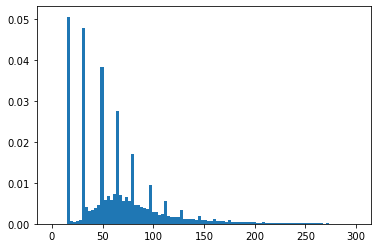

In [7]:
plot.hist(cluster_counts, bins=100, density=True, range=(0,300))

In [5]:
def read_data( sample_event, img_type, data_path=DATA_PATH ):
    """
    Reads single SEVIR event for a given image type.
    
    Parameters
    ----------
    sample_event   pd.DataFrame
        SEVIR catalog rows matching a single ID
    img_type   str
        SEVIR image type
    data_path  str
        Location of SEVIR data
    
    Returns
    -------
    np.array
       LxLx49 tensor containing event data
    """
    fn = sample_event[sample_event.img_type==img_type].squeeze().file_name
    fi = sample_event[sample_event.img_type==img_type].squeeze().file_index
    if(type(fn) is not pd.Series):
        with h5py.File(data_path + '/' + fn,'r') as hf:
            data=hf[img_type][fi] 
        return data
    else:
        return None

In [6]:
def convert_to_norm_cmap(sevir_np_data, sevir_dtype):
    #print(sevir_np_data[:,:,0])
    cmap,norm,vmin,vmax = get_cmap(sevir_dtype)
    sm = matplotlib.cm.ScalarMappable(cmap=cmap,norm=norm)
    new_data = cv2.cvtColor(sm.to_rgba(sevir_np_data).astype(np.float32), cv2.COLOR_RGBA2RGB)
    print(new_data)
    #print(sm.to_rgba(sevir_np_data).shape)
    return cv2.cvtColor(sm.to_rgba(sevir_np_data).astype(np.float32), cv2.COLOR_RGBA2RGB)

In [7]:
catalog = pd.read_csv(CATALOG_PATH,parse_dates=['time_utc'],low_memory=False)
img_types = set(['vis','ir069','ir107','vil'])
events = catalog.groupby('id').filter(lambda x: img_types.issubset(set(x['img_type']))).groupby('id')

def process_datapoint_with_vis_data(datapoint):
    if(datapoint is not None):
        sevir_id = datapoint[0]
        sample_event = events.get_group(sevir_id)
        vis_data = read_data(sample_event, "vis")
        if(vis_data is not None):
            processed_data = []
            for i in range(datapoint[1].shape[-1]):
                datapoint_id = datapoint[0]+"_time_"+str(i)
                processed_data.append((datapoint_id, convert_to_norm_cmap(datapoint[1][:,:,i], "ir069"),cv2.resize(convert_to_norm_cmap(vis_data[:,:,i], "vis"),(192,192)), datapoint[2][i]))
            joblib.dump(processed_data,"./lght_pred_data/"+str(sevir_id)+".pickle")

In [22]:
# process_datapoint_with_vis_data(data[0])

In [12]:
flattened_data = Parallel(n_jobs=16)(delayed(process_datapoint_with_vis_data)(data[j]) for j in tqdm(range(len(data)))) #doctest: +SKIP


100%|██████████| 12739/12739 [1:03:27<00:00,  3.35it/s]


In [8]:
from random import sample
from random import shuffle

def get_num_clusters(sevir_id, time_index):
    label = joblib.load("./lght_pred_data/"+str(sevir_id)+".pickle")[time_index][3]
    return len([key for key in label.keys() if type(key) is not str])

def get_processed_img(sevir_id, time_index):
    return joblib.load("./lght_pred_data/"+str(sevir_id)+".pickle")[time_index]

def sample_events(data,num_train, num_test, num_no_label_train=26000,num_no_label_test=1000):
    possible_samples = []
    for id_index in range(len(data)):
        for time_index in range(49):
            if(data[id_index] is not None):
                possible_samples.append((data[id_index][0], time_index))
    label_lengths = Parallel(n_jobs=32)(delayed(get_num_clusters)(sevir_id, time_index) for sevir_id, time_index in tqdm(possible_samples))
    
    samples = sample(possible_samples, num_train+num_test)
    dataset = Parallel(n_jobs=32)(delayed(get_processed_img)(sevir_id, time_index) for sevir_id, time_index in tqdm(samples))
    joblib.dump(dataset[0:num_train],"./lght_vis_ir069_dataset_train_"+str(num_train)+"_less_no_label.pickle")
    joblib.dump(dataset[num_train:-1],"./lght_vis_ir069_dataset_test_"+str(num_test)+"_.pickle")

In [ ]:
deg 

In [9]:
train_samples = 260000
test_samples = 10000
sample_events(data,train_samples,test_samples)

100%|██████████| 270000/270000 [55:24<00:00, 81.20it/s]  


In [54]:
joblib.dump(flattened_data,"flattened_ir_vis_lght_data.pickle")

['flattened_ir_lght_data.pickle']

In [6]:
#data = joblib.load("flattened_ir_lght_data.pickle")

In [3]:
train_samples = 120000
test_samples = 10000

In [4]:
from random import sample
samples = sample(data, train_samples+test_samples)

In [24]:
conv_samples = []
for samp in samples:
    vis_data = read_data(samp[0], "vis")
    conv_samples.append((samp[0], convert_to_norm_cmap(samp[1], "ir069"), samp[2]))

In [25]:
conv_samples[0][1].shape

(3, 192, 192)

In [26]:
joblib.dump(conv_samples[0:train_samples],"ir_lght_data_train.pickle")
joblib.dump(conv_samples[train_samples:-1],"ir_lght_data_test.pickle")

['ir_lght_data_test.pickle']

In [12]:
import joblib
data = joblib.load("ir_lght_data_test.pickle")

In [4]:
import numpy as np

In [5]:
labels = []
for point in data:
    for obj in point[2].keys():
        if(type(obj) is not str):
            xmin, xmax, ymin, ymax = point[2][obj]["min_x"],point[2][obj]["max_x"],point[2][obj]["min_y"],point[2][obj]["max_y"]
            label = np.clip(25*(point[2][obj]["count"]//25),0,425)
            labels.append(label)

In [6]:
max(labels)

425

In [9]:
len(set(labels))

18

In [11]:
len(range(0,450,25))

18